# CNN ile Görüntü Tanıma Modeli


In [ ]:
# Gerekli kütüphaneler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os


## Veri Hazırlığı

In [ ]:
# Veri yolları
train_dir = "/content/drive/MyDrive/HSD Topluluk/Proje-3/Dataset/train"
val_dir = "/content/drive/MyDrive/HSD Topluluk/Proje-3/Dataset/validation"
test_dir = "/content/drive/MyDrive/HSD Topluluk/Proje-3/Dataset/test"

# Parametreler
img_size = (224, 224)
batch_size = 8

# Eğitim ve doğrulama için ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Veri generatorleri
train_data = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_data = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=1, class_mode='categorical', shuffle=False)


Found 59 images belonging to 3 classes.
Found 18 images belonging to 3 classes.
Found 9 images belonging to 3 classes.


## Basit CNN Modeli Eğitimi

In [ ]:
# CNN Modeli Oluştur
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 sınıf olduğu için
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli Eğit
cnn_history = cnn_model.fit(train_data, validation_data=val_data, epochs=20)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 693ms/step - accuracy: 0.2688 - loss: 4.7498 - val_accuracy: 0.3889 - val_loss: 1.5839
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 891ms/step - accuracy: 0.3703 - loss: 1.1742 - val_accuracy: 0.6111 - val_loss: 0.7748
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 761ms/step - accuracy: 0.7520 - loss: 0.7102 - val_accuracy: 0.7222 - val_loss: 0.5993
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9349 - loss: 0.3573 - val_accuracy: 0.8889 - val_loss: 0.3618
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 623ms/step - accuracy: 0.9055 - loss: 0.3005 - val_accuracy: 0.6667 - val_loss: 0.4613
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 875ms/step - accuracy: 0.9428 - loss: 0.2224 - val_accuracy: 0.6667 - val_loss: 0.5826
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 656ms/step - accuracy: 0.9538 - loss: 0.1531 - val_accuracy: 0.7778 - val_loss: 0.5560
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 901ms/step - accuracy: 0.9186 - loss: 0.1765 - val_accuracy: 0.7778 - val_loss: 

## Model Performansı: Accuracy & Loss

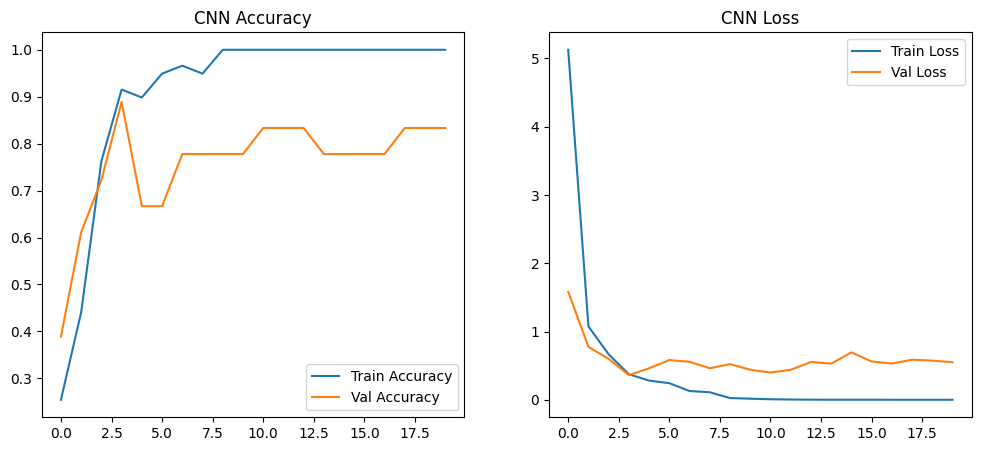

In [ ]:
# Accuracy ve Loss Grafikleri
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('CNN Loss')
plt.legend()

plt.show()


## Confusion Matrix ve Sınıflandırma Raporu

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


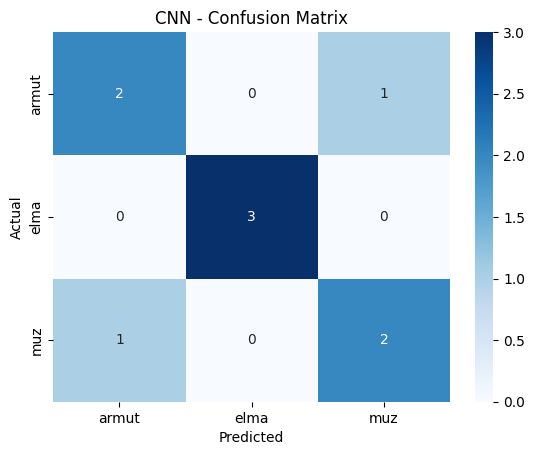

CNN - Classification Report
              precision    recall  f1-score   support

       armut       0.67      0.67      0.67         3
        elma       1.00      1.00      1.00         3
         muz       0.67      0.67      0.67         3

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9



In [ ]:
# Tahminler ve Sınıflar
y_true = test_data.classes
y_pred_cnn = np.argmax(cnn_model.predict(test_data), axis=1)
labels = list(test_data.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_cnn)
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="Blues", fmt='d')
plt.title("CNN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Sınıflandırma Raporu
print("CNN - Classification Report")
print(classification_report(y_true, y_pred_cnn, target_names=labels))


# Transfer Learning ile Görüntü Tanıma Modeli

## Transfer Learning ile ResNet-50 Eğitimi

In [ ]:
# Önceden eğitilmiş ResNet50 yüklenir, üst katmanları dahil edilmez
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Katmanlar dondurulur
for layer in base_model.layers:
    layer.trainable = False

# Üst katmanlar eklenir
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=predictions)
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli Eğit
resnet_history = resnet_model.fit(train_data, validation_data=val_data, epochs=20)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.2479 - loss: 2.0121 - val_accuracy: 0.3333 - val_loss: 1.3506
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3816 - loss: 1.1386 - val_accuracy: 0.3889 - val_loss: 1.2441
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.2897 - loss: 1.1864 - val_accuracy: 0.3333 - val_loss: 1.1414
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4640 - loss: 1.1127 - val_accuracy: 0.2778 - val_loss: 1.1090
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4371 - loss: 1.0681 - val_accuracy: 0.3333 - val_loss: 1.1293
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.3734 - loss: 1.1151 - val_accuracy: 0.3889 - val_loss: 1.1252
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4125 - loss: 1.0616 - val_accuracy: 0.3889 - val_loss: 1.0983
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3462 - loss: 1.0898 - val_accuracy: 0.3333 - val_loss: 1.1042
Epoch 9/

## ResNet Model Performansı

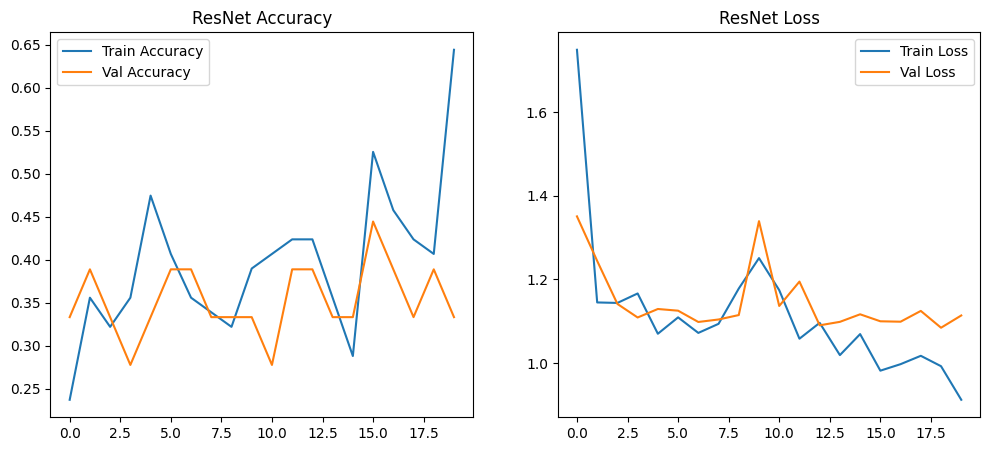

In [ ]:
# Accuracy ve Loss Grafikleri
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(resnet_history.history['accuracy'], label='Train Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Val Accuracy')
plt.title('ResNet Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(resnet_history.history['loss'], label='Train Loss')
plt.plot(resnet_history.history['val_loss'], label='Val Loss')
plt.title('ResNet Loss')
plt.legend()

plt.show()


## ResNet: Confusion Matrix ve Rapor

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step


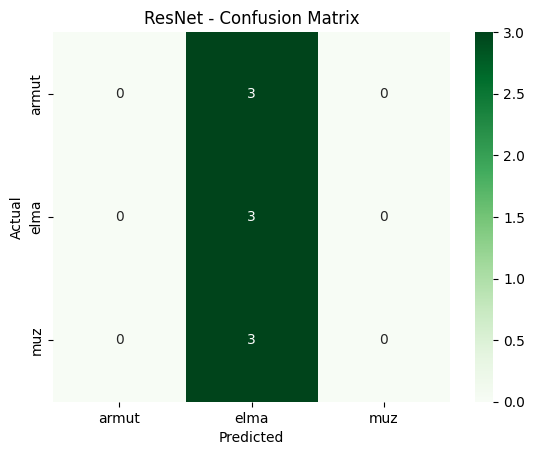

ResNet - Classification Report
              precision    recall  f1-score   support

       armut       0.00      0.00      0.00         3
        elma       0.33      1.00      0.50         3
         muz       0.00      0.00      0.00         3

    accuracy                           0.33         9
   macro avg       0.11      0.33      0.17         9
weighted avg       0.11      0.33      0.17         9



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Tahminler
y_pred_resnet = np.argmax(resnet_model.predict(test_data), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_resnet)
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="Greens", fmt='d')
plt.title("ResNet - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Sınıflandırma Raporu
print("ResNet - Classification Report")
print(classification_report(y_true, y_pred_resnet, target_names=labels))


**Daha Kaliteli Bir Eğitim için**


1.   Veri kalitesi arttırılmalı
*   Veriler yeterli sayıda olmalıdır.
*   Görüntülerin boyutları aynı olmalıdır.
2.   Model eğitimi için yeterli süre verilmelidir
*   Beklenen model performansına oranla başta epoch sayısı olmak üzere model hiperparametreleri güncellenmelidir.
*   Her zaman uzun eğitim doğru eğitim değildir. Modelin aşırı öğrenmesine engel olunmalıdır.
3.  Model karmaşıklığı arttırılabilir
*   Daha karmaşık modeller, daha doğru sonuçlar getirebilirler.

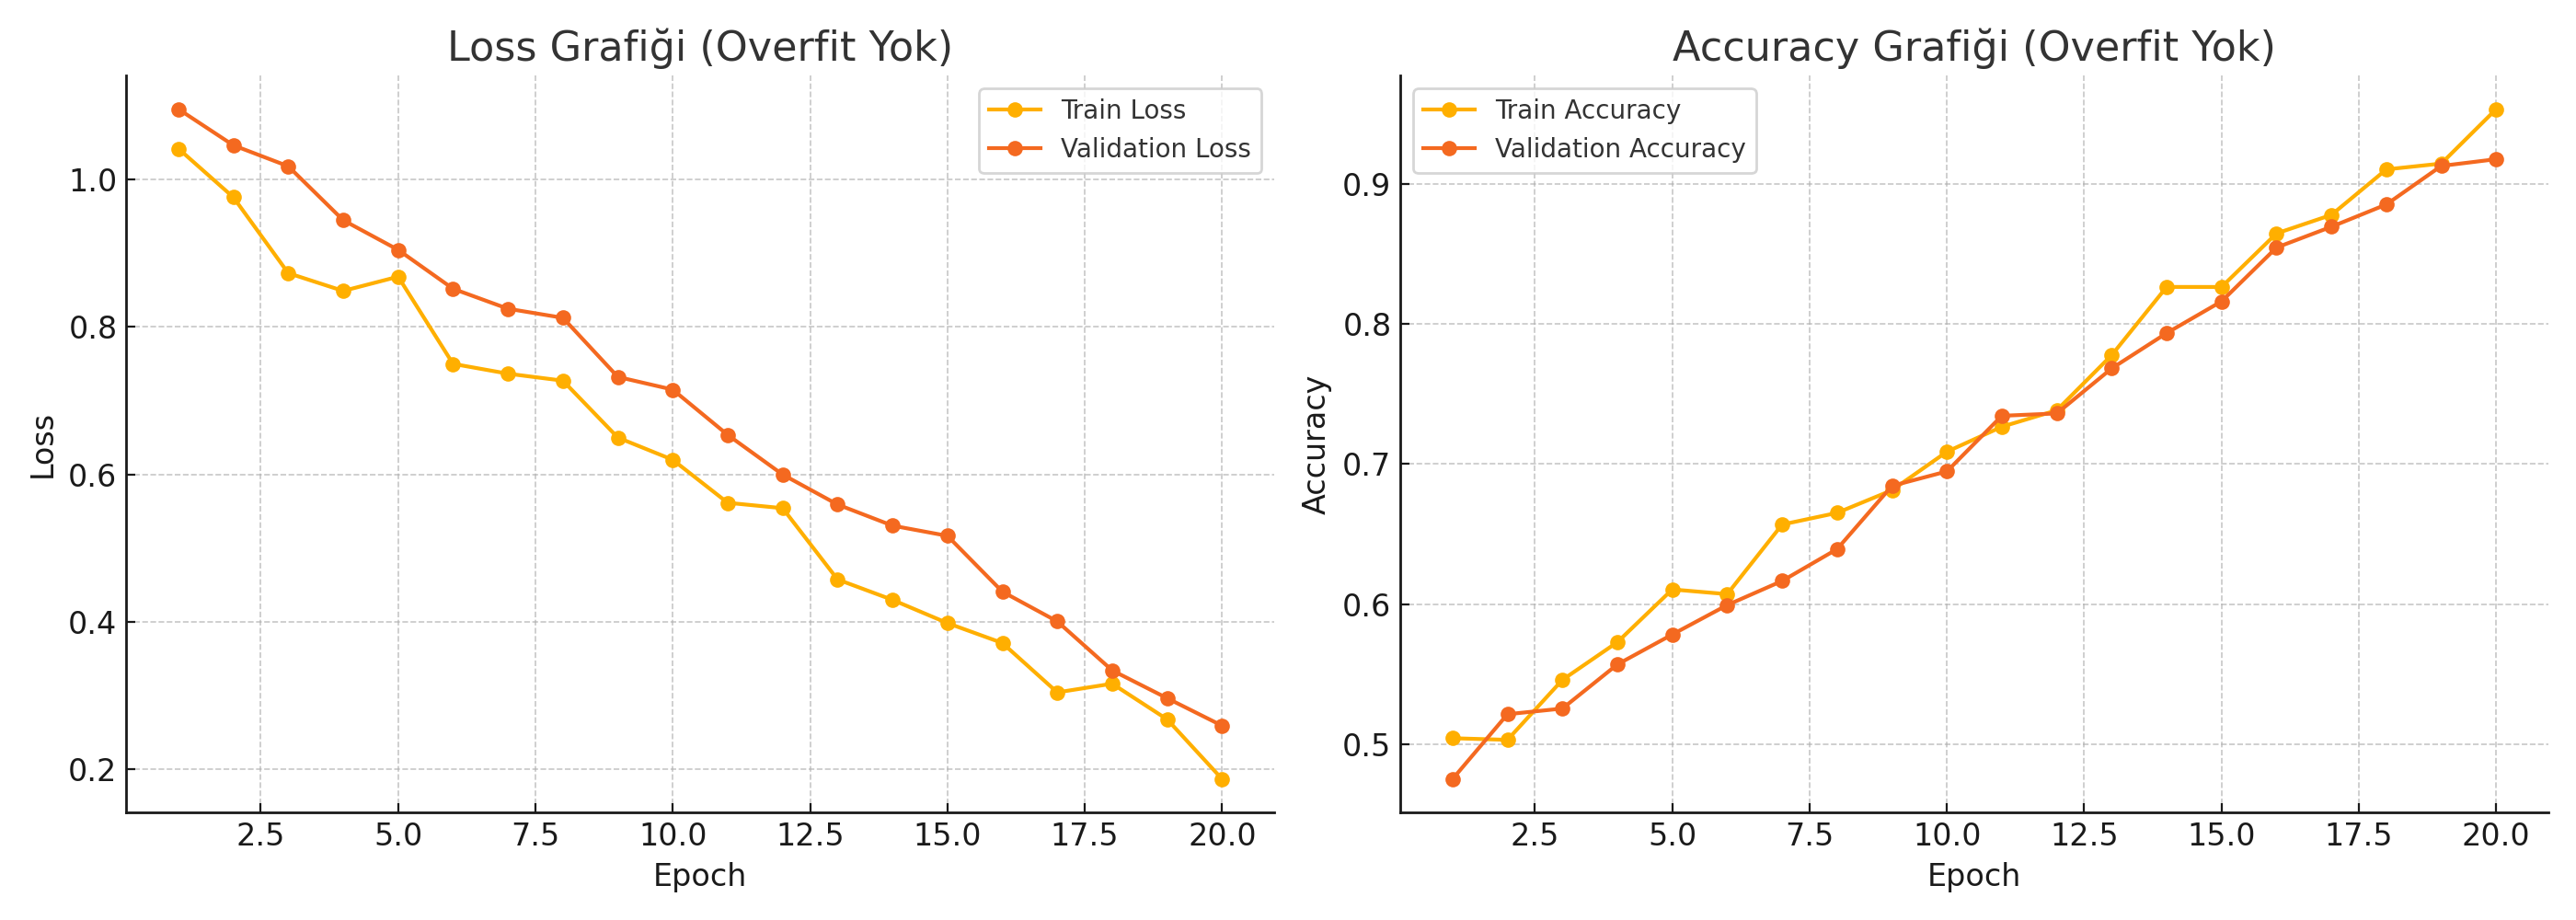

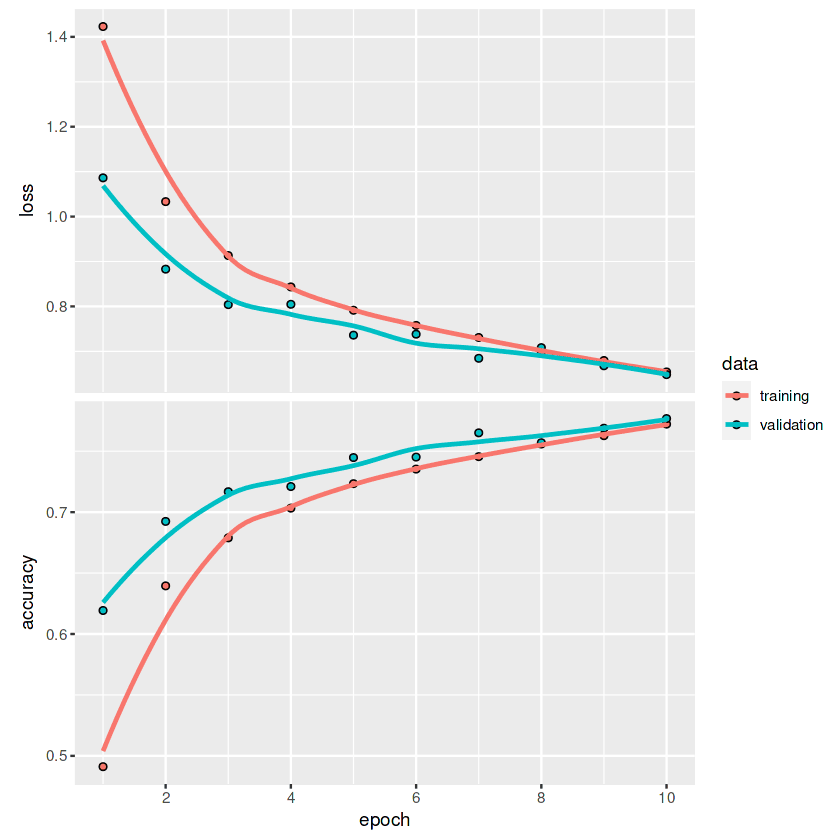

from Datacamp